# Feature-based mitotic classifier using gradient boosted decision trees

In [1]:
import os, sys, gc, itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.core.display import display

## Plotting and analysis functions

In [2]:
def modelAnalysis(test_y, predict):
    target_na = ["not mitotic", "M1: prophase 1", "M2: prophase 2", "M3: pro metaphase 1", 
                 "M4: pro metaphase 2", "M5: metaphase", "M6: anaphase", "M7: telophase-cytokinesis"]
        
    print(classification_report(test_y, predict, target_names=target_na))
    print('accuracy', accuracy_score(test_y, predict))
    mat = confusion_matrix(test_y, predict)
    
    target_na = np.array(target_na)
    plt.figure(figsize=(10,10))
    a = plot_confusion_matrix(mat, classes = target_na, normalize = False)
    plt.grid(b=False)
    plt.show()

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    temp = []
    mat = cm
    for i in range(len(mat)):
        temp.append((mat[i, :].astype(np.float64)/(sum(mat[i])+1e-32).tolist()))
    
    mat = np.array(temp)
    
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = sum(cm[i])/ 2.
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def make_X_y_from_df(dataframe, X_cols, y_col,
                     make_y_int=True, drop_bad_vals=True):
    
    dataframe = dataframe[[y_col, *X_cols]]
    
    if drop_bad_vals:
        dataframe = dataframe.dropna()
        dataframe = dataframe[dataframe[target_col] >= 0]

    y = dataframe[y_col]
    X = dataframe[X_cols].values
    
    if make_y_int:
        le = LabelEncoder()
        le.fit(y)
        y = le.transform(y)
    else:
        y = y.values
        
    return X,y

## use ZY's feats

### Load data

In [5]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Microscopy', df.query('MitoticHandoff == "Microscopy"').shape)

df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Microscopy"')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Microscopy (323, 2531)


In [6]:
target_col = 'MitosisLabel'
feature_cols = ['feat_nuc_region_std_px',
                'feat_nuc_mt_edge_3',
                'feat_nuc_mt_edge_8',
                'feat_nuc_mt_edge_9',
                'feat_nuc_mt_edge_10',
                'feat_nuc_mt_edge_15',
                'feat_cell_obj_mean_depth',
                'feat_nuc_obj_tot_sphericity',
                'feat_nuc_obj_max_spherical_obj',
                'feat_nuc_obj_mean_spherical_obj']

### Train and test set -- use to find a good model

In [7]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

### Validation set -- held out until after model is locked down

In [8]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2324,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'num_iterations': 1000,
    'n_estimators': 100,
    'verbose': 0,
    'early_stopping_rounds': 5
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 2.0396
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 2.00134
[3]	valid_0's multi_logloss: 1.96456
[4]	valid_0's multi_logloss: 1.92914
[5]	valid_0's multi_logloss: 1.89498
[6]	valid_0's multi_logloss: 1.86202
[7]	valid_0's multi_logloss: 1.83016
[8]	valid_0's multi_logloss: 1.79934
[9]	valid_0's multi_logloss: 1.76949
[10]	valid_0's multi_logloss: 1.74056
[11]	valid_0's multi_logloss: 1.71251
[12]	valid_0's multi_logloss: 1.68526
[13]	valid_0's multi_logloss: 1.65879
[14]	valid_0's multi_logloss: 1.63306
[15]	valid_0's multi_logloss: 1.60802
[16]	valid_0's multi_logloss: 1.58365
[17]	valid_0's multi_logloss: 1.55991
[18]	valid_0's multi_logloss: 1.53677
[19]	valid_0's multi_logloss: 1.5142
[20]	valid_0's multi_logloss: 1.49217
[21]	valid_0's multi_logloss: 1.47068
[22]	valid_0's multi_logloss: 1.44969
[23]	valid_0's multi_logloss: 1.42917
[24]	valid_0's multi_logloss: 1.40912
[25]	valid_0's multi_logloss: 1.38952


[228]	valid_0's multi_logloss: 0.153129
[229]	valid_0's multi_logloss: 0.151605
[230]	valid_0's multi_logloss: 0.150096
[231]	valid_0's multi_logloss: 0.148603
[232]	valid_0's multi_logloss: 0.147125
[233]	valid_0's multi_logloss: 0.145663
[234]	valid_0's multi_logloss: 0.144215
[235]	valid_0's multi_logloss: 0.142782
[236]	valid_0's multi_logloss: 0.141364
[237]	valid_0's multi_logloss: 0.139961
[238]	valid_0's multi_logloss: 0.138572
[239]	valid_0's multi_logloss: 0.137197
[240]	valid_0's multi_logloss: 0.135836
[241]	valid_0's multi_logloss: 0.134489
[242]	valid_0's multi_logloss: 0.133156
[243]	valid_0's multi_logloss: 0.131836
[244]	valid_0's multi_logloss: 0.13053
[245]	valid_0's multi_logloss: 0.129238
[246]	valid_0's multi_logloss: 0.127958
[247]	valid_0's multi_logloss: 0.126691
[248]	valid_0's multi_logloss: 0.125438
[249]	valid_0's multi_logloss: 0.124197
[250]	valid_0's multi_logloss: 0.122969
[251]	valid_0's multi_logloss: 0.121754
[252]	valid_0's multi_logloss: 0.12055
[2

[454]	valid_0's multi_logloss: 0.0188988
[455]	valid_0's multi_logloss: 0.0187431
[456]	valid_0's multi_logloss: 0.0185927
[457]	valid_0's multi_logloss: 0.01845
[458]	valid_0's multi_logloss: 0.0183066
[459]	valid_0's multi_logloss: 0.0181608
[460]	valid_0's multi_logloss: 0.0180226
[461]	valid_0's multi_logloss: 0.017871
[462]	valid_0's multi_logloss: 0.0177331
[463]	valid_0's multi_logloss: 0.0175942
[464]	valid_0's multi_logloss: 0.0174595
[465]	valid_0's multi_logloss: 0.0173208
[466]	valid_0's multi_logloss: 0.0171931
[467]	valid_0's multi_logloss: 0.017067
[468]	valid_0's multi_logloss: 0.0169447
[469]	valid_0's multi_logloss: 0.0168214
[470]	valid_0's multi_logloss: 0.0167018
[471]	valid_0's multi_logloss: 0.0165809
[472]	valid_0's multi_logloss: 0.0164517
[473]	valid_0's multi_logloss: 0.0163336
[474]	valid_0's multi_logloss: 0.0162168
[475]	valid_0's multi_logloss: 0.0161034
[476]	valid_0's multi_logloss: 0.015989
[477]	valid_0's multi_logloss: 0.0158662
[478]	valid_0's multi

[672]	valid_0's multi_logloss: 0.00660265
[673]	valid_0's multi_logloss: 0.00659222
[674]	valid_0's multi_logloss: 0.00657497
[675]	valid_0's multi_logloss: 0.00656629
[676]	valid_0's multi_logloss: 0.00654527
[677]	valid_0's multi_logloss: 0.00652498
[678]	valid_0's multi_logloss: 0.00651676
[679]	valid_0's multi_logloss: 0.00650462
[680]	valid_0's multi_logloss: 0.00648468
[681]	valid_0's multi_logloss: 0.00647694
[682]	valid_0's multi_logloss: 0.00647934
[683]	valid_0's multi_logloss: 0.00645969
[684]	valid_0's multi_logloss: 0.0064515
[685]	valid_0's multi_logloss: 0.00643088
[686]	valid_0's multi_logloss: 0.00642001
[687]	valid_0's multi_logloss: 0.00641207
[688]	valid_0's multi_logloss: 0.00640603
[689]	valid_0's multi_logloss: 0.00639572
[690]	valid_0's multi_logloss: 0.00638904
[691]	valid_0's multi_logloss: 0.00636955
[692]	valid_0's multi_logloss: 0.00636214
[693]	valid_0's multi_logloss: 0.00635257
[694]	valid_0's multi_logloss: 0.00634729
[695]	valid_0's multi_logloss: 0.00

### Training performance on  old data

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99      3361
           M1: prophase 1       0.00      0.00      0.00        26
           M2: prophase 2       0.89      0.80      0.84        20
      M3: pro metaphase 1       1.00      0.55      0.71        11
      M4: pro metaphase 2       0.83      1.00      0.91        34
            M5: metaphase       1.00      0.65      0.79        17
             M6: anaphase       0.94      0.68      0.79        25
M7: telophase-cytokinesis       0.86      0.86      0.86        71

              avg / total       0.98      0.98      0.98      3565

accuracy 0.983450210379


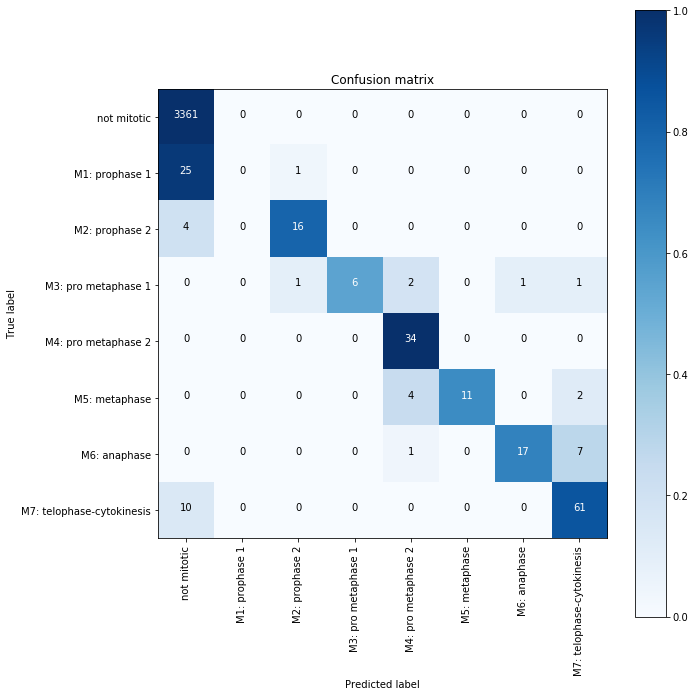

In [11]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on old data

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

              not mitotic       0.98      1.00      0.99       846
           M1: prophase 1       0.00      0.00      0.00         5
           M2: prophase 2       0.00      0.00      0.00         2
      M3: pro metaphase 1       1.00      0.20      0.33         5
      M4: pro metaphase 2       0.38      1.00      0.56         5
            M5: metaphase       0.00      0.00      0.00         6
             M6: anaphase       1.00      0.50      0.67         2
M7: telophase-cytokinesis       0.78      0.67      0.72        21

              avg / total       0.96      0.97      0.96       892

accuracy 0.970852017937


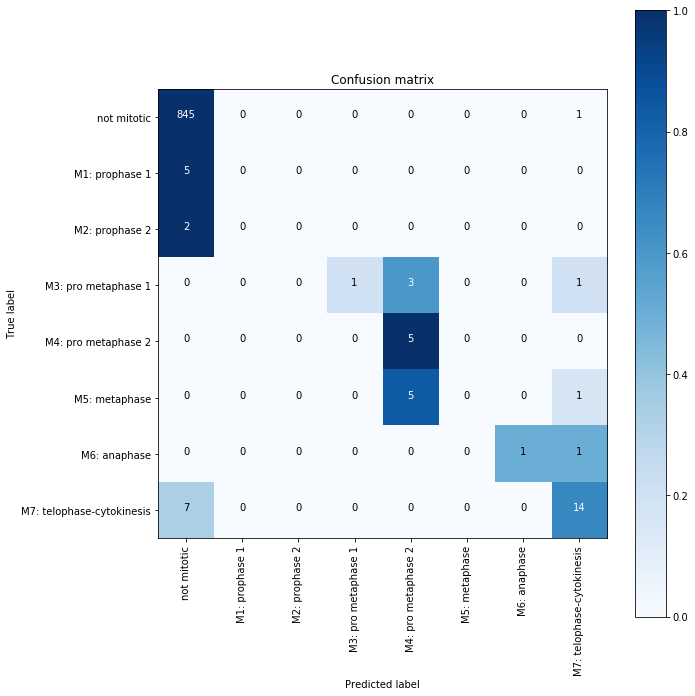

In [12]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

## Use all features

### Load data

In [13]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df = df.dropna(subset=['MitosisLabel'])

print('Release', df.query('MitoticHandoff == "Release"').shape)
print('Ongoing', df.query('MitoticHandoff == "Ongoing"').shape)
print('Microscopy', df.query('MitoticHandoff == "Microscopy"').shape)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Release (4457, 2531)
Ongoing (2349, 2531)
Microscopy (323, 2531)


In [14]:
target_col = 'MitosisLabel'
feature_cols = df.columns[df.columns.str.contains(pat = 'feat_')]

df = df.fillna(0)
df = df[df[target_col] >= 0]
df_release = df.query('MitoticHandoff == "Release"')
df_ongoing = df.query('MitoticHandoff == "Ongoing" | MitoticHandoff == "Microscopy"')

### Train and test set -- use to find a good model

In [15]:
X_train_test, y_train_test = make_X_y_from_df(df_release,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_train_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([4207,   31,   22,   16,   39,   23,   27,   92]))

### Validation set -- held out until after model is locked down

In [16]:
X_validation, y_validation = make_X_y_from_df(df_ongoing,
                                              feature_cols,
                                              target_col,
                                              make_y_int=True)
np.unique(y_validation, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([2324,   15,    8,   30,   59,   30,   44,  162]))

### Split train and test apart

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test,
                                                    test_size=0.2,
                                                    random_state=42)

unique_classes, class_counts = np.unique(y_train_test, return_counts=True)
class_weights = class_counts/np.sum(class_counts)
class_weights

lgb_train = lgb.Dataset(X_train, y_train,
                        weight=np.array([class_weights[int(i)] for i in y_train]),
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train,
                        weight=np.array([class_weights[int(i)] for i in y_test]),
                       free_raw_data=False)

### Train the model

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(unique_classes),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'max_depth': 6,
    'learning_rate': 0.01,
    'num_iterations': 1000,
    'n_estimators': 100,
    'verbose': 0,
    'early_stopping_rounds': 5
}

gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_test)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:103: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 2.03961
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 2.0014
[3]	valid_0's multi_logloss: 1.96466
[4]	valid_0's multi_logloss: 1.92928
[5]	valid_0's multi_logloss: 1.89517
[6]	valid_0's multi_logloss: 1.86225
[7]	valid_0's multi_logloss: 1.83043
[8]	valid_0's multi_logloss: 1.79965
[9]	valid_0's multi_logloss: 1.76985
[10]	valid_0's multi_logloss: 1.74096
[11]	valid_0's multi_logloss: 1.71293
[12]	valid_0's multi_logloss: 1.68573
[13]	valid_0's multi_logloss: 1.65929
[14]	valid_0's multi_logloss: 1.63359
[15]	valid_0's multi_logloss: 1.60858
[16]	valid_0's multi_logloss: 1.58424
[17]	valid_0's multi_logloss: 1.56053
[18]	valid_0's multi_logloss: 1.53741
[19]	valid_0's multi_logloss: 1.51487
[20]	valid_0's multi_logloss: 1.49288
[21]	valid_0's multi_logloss: 1.47141
[22]	valid_0's multi_logloss: 1.45044
[23]	valid_0's multi_logloss: 1.42996
[24]	valid_0's multi_logloss: 1.40993
[25]	valid_0's multi_logloss: 1.39035

[212]	valid_0's multi_logloss: 0.182943
[213]	valid_0's multi_logloss: 0.181166
[214]	valid_0's multi_logloss: 0.179399
[215]	valid_0's multi_logloss: 0.177659
[216]	valid_0's multi_logloss: 0.175928
[217]	valid_0's multi_logloss: 0.174224
[218]	valid_0's multi_logloss: 0.172528
[219]	valid_0's multi_logloss: 0.17085
[220]	valid_0's multi_logloss: 0.169199
[221]	valid_0's multi_logloss: 0.167555
[222]	valid_0's multi_logloss: 0.165938
[223]	valid_0's multi_logloss: 0.164331
[224]	valid_0's multi_logloss: 0.162736
[225]	valid_0's multi_logloss: 0.16117
[226]	valid_0's multi_logloss: 0.159608
[227]	valid_0's multi_logloss: 0.158074
[228]	valid_0's multi_logloss: 0.156523
[229]	valid_0's multi_logloss: 0.15501
[230]	valid_0's multi_logloss: 0.153491
[231]	valid_0's multi_logloss: 0.152012
[232]	valid_0's multi_logloss: 0.150525
[233]	valid_0's multi_logloss: 0.149082
[234]	valid_0's multi_logloss: 0.14765
[235]	valid_0's multi_logloss: 0.146207
[236]	valid_0's multi_logloss: 0.144808
[237

[417]	valid_0's multi_logloss: 0.0275667
[418]	valid_0's multi_logloss: 0.0273318
[419]	valid_0's multi_logloss: 0.0271015
[420]	valid_0's multi_logloss: 0.0268953
[421]	valid_0's multi_logloss: 0.0266704
[422]	valid_0's multi_logloss: 0.0264444
[423]	valid_0's multi_logloss: 0.0262438
[424]	valid_0's multi_logloss: 0.0260215
[425]	valid_0's multi_logloss: 0.0258001
[426]	valid_0's multi_logloss: 0.0255859
[427]	valid_0's multi_logloss: 0.0253638
[428]	valid_0's multi_logloss: 0.0251525
[429]	valid_0's multi_logloss: 0.0249356
[430]	valid_0's multi_logloss: 0.0247475
[431]	valid_0's multi_logloss: 0.0245423
[432]	valid_0's multi_logloss: 0.0243329
[433]	valid_0's multi_logloss: 0.0241352
[434]	valid_0's multi_logloss: 0.0239353
[435]	valid_0's multi_logloss: 0.0237295
[436]	valid_0's multi_logloss: 0.023551
[437]	valid_0's multi_logloss: 0.0233766
[438]	valid_0's multi_logloss: 0.0232037
[439]	valid_0's multi_logloss: 0.0230329
[440]	valid_0's multi_logloss: 0.0228652
[441]	valid_0's m

[620]	valid_0's multi_logloss: 0.00771676
[621]	valid_0's multi_logloss: 0.00767899
[622]	valid_0's multi_logloss: 0.00765111
[623]	valid_0's multi_logloss: 0.00761851
[624]	valid_0's multi_logloss: 0.00757569
[625]	valid_0's multi_logloss: 0.00754226
[626]	valid_0's multi_logloss: 0.00750248
[627]	valid_0's multi_logloss: 0.00747132
[628]	valid_0's multi_logloss: 0.00744428
[629]	valid_0's multi_logloss: 0.00740938
[630]	valid_0's multi_logloss: 0.00737274
[631]	valid_0's multi_logloss: 0.00734201
[632]	valid_0's multi_logloss: 0.00730508
[633]	valid_0's multi_logloss: 0.0072721
[634]	valid_0's multi_logloss: 0.00723789
[635]	valid_0's multi_logloss: 0.00721392
[636]	valid_0's multi_logloss: 0.00718486
[637]	valid_0's multi_logloss: 0.00714916
[638]	valid_0's multi_logloss: 0.00712148
[639]	valid_0's multi_logloss: 0.00711043
[640]	valid_0's multi_logloss: 0.00709151
[641]	valid_0's multi_logloss: 0.00707266
[642]	valid_0's multi_logloss: 0.00705819
[643]	valid_0's multi_logloss: 0.00

[816]	valid_0's multi_logloss: 0.0048828
[817]	valid_0's multi_logloss: 0.00486767
[818]	valid_0's multi_logloss: 0.0048566
[819]	valid_0's multi_logloss: 0.00484297
[820]	valid_0's multi_logloss: 0.00482883
[821]	valid_0's multi_logloss: 0.00480808
[822]	valid_0's multi_logloss: 0.00479086
[823]	valid_0's multi_logloss: 0.00477489
[824]	valid_0's multi_logloss: 0.0047544
[825]	valid_0's multi_logloss: 0.00474959
[826]	valid_0's multi_logloss: 0.0047359
[827]	valid_0's multi_logloss: 0.00471982
[828]	valid_0's multi_logloss: 0.00470067
[829]	valid_0's multi_logloss: 0.00468421
[830]	valid_0's multi_logloss: 0.00467007
[831]	valid_0's multi_logloss: 0.00465485
[832]	valid_0's multi_logloss: 0.00463831
[833]	valid_0's multi_logloss: 0.00463504
[834]	valid_0's multi_logloss: 0.00461549
[835]	valid_0's multi_logloss: 0.00460647
[836]	valid_0's multi_logloss: 0.00459349
[837]	valid_0's multi_logloss: 0.00458091
[838]	valid_0's multi_logloss: 0.00456172
[839]	valid_0's multi_logloss: 0.00454

### Training performance on  old data

                           precision    recall  f1-score   support

              not mitotic       1.00      1.00      1.00      3361
           M1: prophase 1       1.00      0.92      0.96        26
           M2: prophase 2       1.00      0.95      0.97        20
      M3: pro metaphase 1       1.00      1.00      1.00        11
      M4: pro metaphase 2       1.00      1.00      1.00        34
            M5: metaphase       1.00      1.00      1.00        17
             M6: anaphase       1.00      1.00      1.00        25
M7: telophase-cytokinesis       1.00      1.00      1.00        71

              avg / total       1.00      1.00      1.00      3565

accuracy 0.999158485273


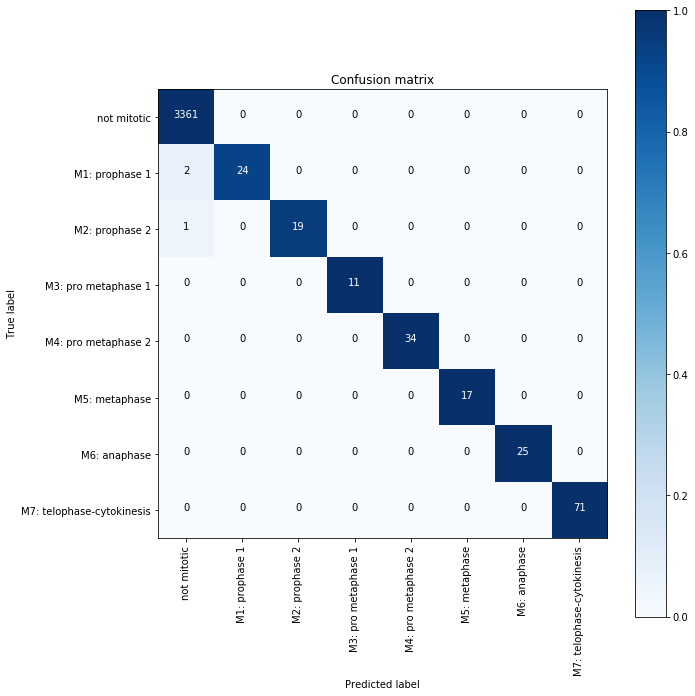

In [19]:
pred_classes_train = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_train)])
modelAnalysis(y_train, pred_classes_train)

### Testing performance on  old data

                           precision    recall  f1-score   support

              not mitotic       0.99      1.00      0.99       846
           M1: prophase 1       0.00      0.00      0.00         5
           M2: prophase 2       0.00      0.00      0.00         2
      M3: pro metaphase 1       1.00      0.40      0.57         5
      M4: pro metaphase 2       0.50      0.80      0.62         5
            M5: metaphase       0.67      0.33      0.44         6
             M6: anaphase       1.00      0.50      0.67         2
M7: telophase-cytokinesis       0.75      0.71      0.73        21

              avg / total       0.97      0.97      0.97       892

accuracy 0.973094170404


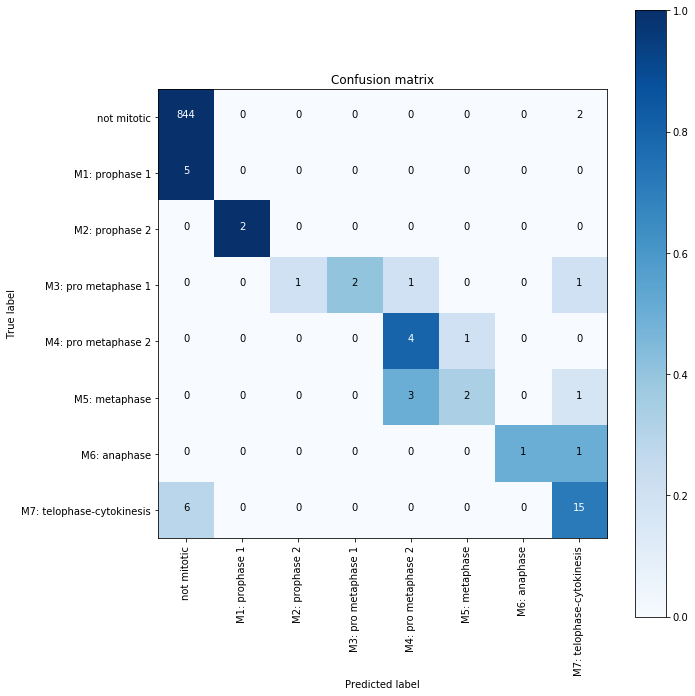

In [20]:
pred_classes_test = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_test)])
modelAnalysis(y_test, pred_classes_test)

### Validation performance on new held-out data

                           precision    recall  f1-score   support

              not mitotic       0.97      1.00      0.98      2324
           M1: prophase 1       1.00      0.07      0.12        15
           M2: prophase 2       1.00      0.75      0.86         8
      M3: pro metaphase 1       0.60      0.20      0.30        30
      M4: pro metaphase 2       0.53      0.53      0.53        59
            M5: metaphase       0.52      0.47      0.49        30
             M6: anaphase       0.56      0.20      0.30        44
M7: telophase-cytokinesis       0.69      0.66      0.68       162

              avg / total       0.93      0.93      0.93      2672

accuracy 0.934505988024


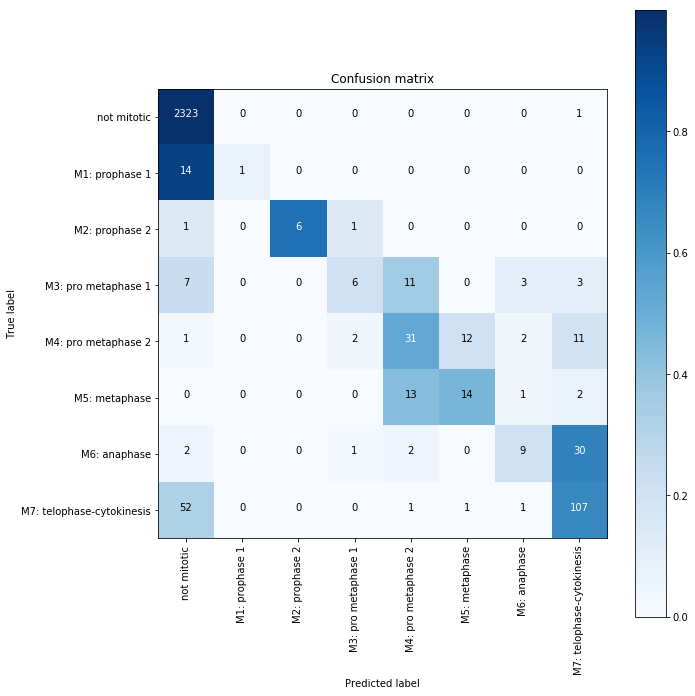

In [21]:
pred_classes_valid = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_validation)])
modelAnalysis(y_validation, pred_classes_valid)

## Predict on unannotated cells

### Load data

In [22]:
data_dir = "/home/jovyan/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31"
csv_name = "feats_out_mitotic_annotations.csv"
df = pd.read_csv(os.path.join(data_dir,csv_name))

df_unknown = df[pd.isnull(df['MitosisLabel'])]
df_unknown.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,13,26,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(14839, 2531)

### Perform predictions

In [23]:
X_unknown = df_unknown[feature_cols].values
pred_classes_unknown = np.array([np.argmax(pred_vec) for pred_vec in gbm.predict(X_unknown)])
np.unique(pred_classes_unknown, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([14072,     5,    32,    26,   198,    40,    23,   443]))

### Merge in predictions

In [24]:
# pick out some minimally useful columns to save
df_unknown_key_and_ims = df_unknown[['inputFolder',
                                     'inputFilename',
                                     'outputThisCellIndex',
                                     'save_flat_reg_path',
                                     'save_flat_proj_reg_path']]

# add in predicted mitotic class
df_unknown_key_and_ims['predicted_class'] = pd.Series(pred_classes_unknown, index=df_unknown_key_and_ims.index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Visually inspect predictions

#### Some images aren't actrually there!  this needs to get fixed!

In [25]:
df_unknown_key_and_ims.shape

(14839, 6)

In [26]:
# find files with nonzero size

im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'

df_unknown_key_and_ims['file_size'] = pd.Series(np.zeros(len(df_unknown_key_and_ims)))
for index, row in tqdm_notebook(df_unknown_key_and_ims.iterrows(),
                                total=len(df_unknown_key_and_ims),
                                desc='scanning files'):

    # for each file listed
    full_file_path = os.path.join(im_dir, df_unknown_key_and_ims.loc[index, 'save_flat_proj_reg_path'])

    # record the file size if it exists else recors zero
    df_unknown_key_and_ims.loc[index, 'file_size'] = os.path.getsize(full_file_path) if \
                                                         os.path.isfile(full_file_path) else \
                                                         np.NaN

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


HBox(children=(IntProgress(value=0, description='scanning files', max=14839), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Compare all un-annotated predictions to predictions on un-annoted cells where we actually have the pngs

In [27]:
np.unique(df_unknown_key_and_ims['predicted_class'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([14072,     5,    32,    26,   198,    40,    23,   443]))

In [28]:
df_unknown_key_and_ims_present = df_unknown_key_and_ims.dropna(subset=['file_size'])
np.unique(df_unknown_key_and_ims_present['predicted_class'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([11701,     4,    27,    18,   163,    35,    21,   259]))

### Inspect predictions visually on samples

phase 0:


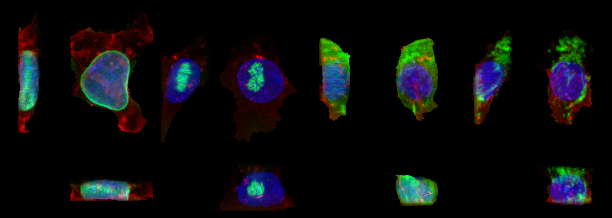

phase 1:


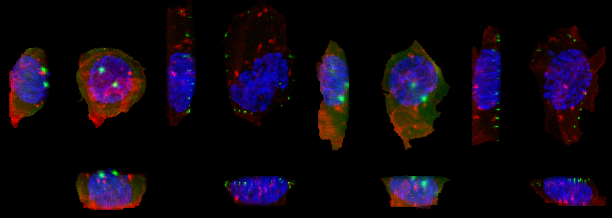

phase 2:


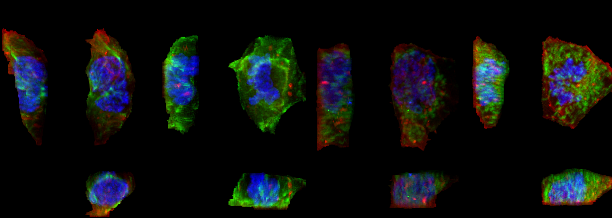

phase 3:


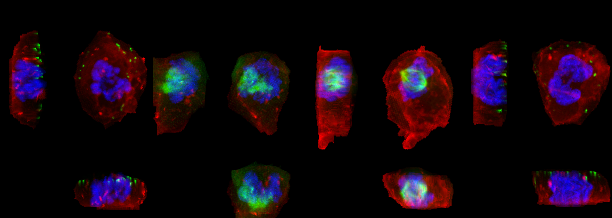

phase 4:


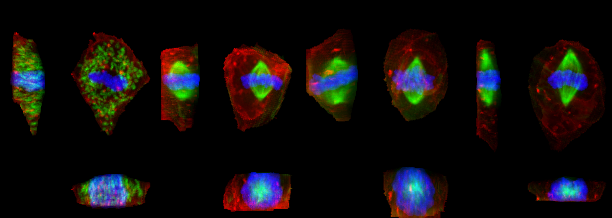

phase 5:


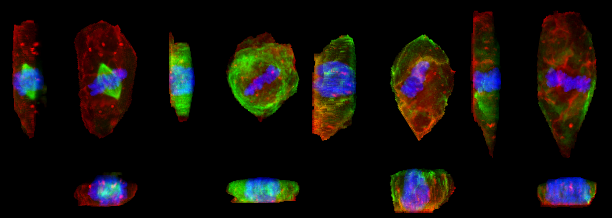

phase 6:


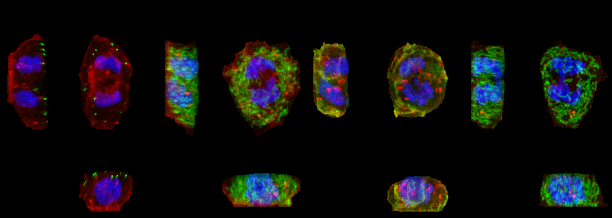

phase 7:


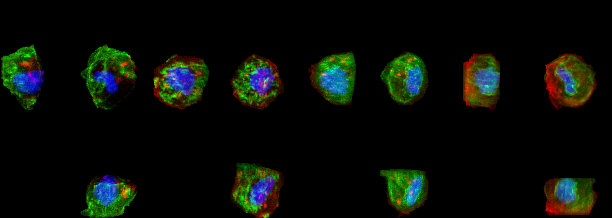

In [29]:
im_dir = '/home/jovyan/aics/modeling/gregj/results/ipp_17_10_31'
img_dims = (218,153,3)
N_samples = 4
image_stacks = {}

for c in np.unique(df_unknown_key_and_ims_present['predicted_class']):
    query_string = 'predicted_class == {}'.format(c)
    pred_c_samples = df_unknown_key_and_ims_present.query(query_string)["save_flat_proj_reg_path"].sample(N_samples).values
    
    image_stack = np.zeros(shape=(img_dims[0],0,img_dims[2]), dtype=np.uint8)
    for i,img_loc in enumerate(pred_c_samples):
        img_path = os.path.join(im_dir,img_loc)
        this_img = np.array(Image.open(img_path))
        this_img = this_img[:img_dims[0],:img_dims[1],:img_dims[2]]
        image_stack = np.hstack([image_stack, this_img])
    image_stacks[c] = image_stack
    
for k,v in image_stacks.items():
    image = Image.fromarray(v)
    print('phase {}:'.format(k))
    display(image)

#### Save prediction csv

In [31]:
df_unknown_key_and_ims.to_csv('mitotic_predictions_gbdts.csv', index=False)